# 6 线性模型的筛选和正则化

首先我们考虑一个多元回归模型：    
$$
 Y = \beta_0 + \beta_1X_1 + ... + \beta_pX_p + \epsilon
$$   
这通常用来描述因变量 Y 和一组解释变量 X 之间的关系。我们通常用最小二乘法拟合这个模型。  

##### 为什么我们要考虑一种其他的拟合模型来代替OLS模型?     

-预测精度:如果 n 比 p 小，或者 p > n 但是大不了多少，则传统的OLS不能应用于此。   
-模型的可解释性: 将不相关的变量包含到模型中会导致不必要的复杂性。    

##### 三种选择模型的方法:
- 线性模型筛选
- 压缩
- 降维

## 6.1 利用子集选择

###### <font color="#0000dd">Algorithm 6.1 Best Subset Selection</font>
1. 令 $M_0$ 定义为 $null$ $model$, 不包含任何的解释变量。该模型仅预测每次观测的样本平均值。
2. 对于 $k = 1,2,...p$:   
    (a)拟合所有的 $C_p^k$ 模型包含 $k$ 个解释变量。
    (b) 从所有的 $C_p^k$ 个模型中选择的最优的模型($M_k$). $最优的$ 定义为含有最小的 RSS 或者最大的 $R^2$.
3. 从所有的 $M_0,...,M_p$ 个模型中选择最合适的，使用交叉项的预测误差, $C_p$(AIC), BIC, 或调整后的 $R^2$

In [19]:
import pandas as pd
import numpy as np
from itertools import combinations
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso,RidgeCV, LassoCV
from sklearn.preprocessing import scale 

In [20]:
def BestSubset(y,X,krange=11):
    score = []
    for k in range(1,krange+1):
        var = combinations(X.columns, k)
        for subset in var:
            model = sm.OLS(list(y),sm.add_constant(X[list(subset)]).astype(float)).fit()
            score.append([k, subset, model.ssr, model.rsquared, model.rsquared_adj,model.aic, model.bic])
    return score
#combinations表示了一种排列组合的方法
#利用append在最后追加对象，将需要的信息粘到空的score中

In [22]:
Credit = pd.read_csv('Credit.csv', index_col = 0)
Credit = pd.get_dummies(Credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
#one-hot的基本思想：将离散型特征的每一种取值都看成一种状态，若你的这一特征中有N个不相同的取值，那么我们就可以将该特征抽象成N种不同的状态
y = Credit.Balance
X = Credit.drop('Balance',axis=1)
#调用刚才的函数
Best_score = BestSubset(Credit.Balance,Credit.drop('Balance',axis=1))
Best_score = pd.DataFrame(Best_score, columns= ['k','var','RSS','R2','R2_adj','AIC','BIC'])
n = len(y)

Best_score['Cp'] = (Best_score.RSS + 2*Best_score.k*(Best_score.RSS/(n-1-Best_score.k)))/n

RSSmin = Best_score.groupby('k').RSS.min()
R2max = Best_score.groupby('k').R2.max()
Best_score1 = Best_score.sort_values('RSS')
bestvar = Best_score1.groupby('k').head(1)['var']
#按照k分组
print(Credit)
print(RSSmin)
print(Best_score)

      Income  Limit  Rating  Cards  Age  Education  Balance  Gender_Male  \
1     14.891   3606     283      2   34         11      333            1   
2    106.025   6645     483      3   82         15      903            0   
3    104.593   7075     514      4   71         11      580            1   
4    148.924   9504     681      3   36         11      964            0   
5     55.882   4897     357      2   68         16      331            1   
..       ...    ...     ...    ...  ...        ...      ...          ...   
396   12.096   4100     307      3   32         13      560            1   
397   13.364   3838     296      5   65         17      480            1   
398   57.872   4171     321      5   67         12      138            0   
399   37.728   2525     192      1   44         13        0            1   
400   18.701   5524     415      5   64          7      966            0   

     Student_Yes  Married_Yes  Ethnicity_Asian  Ethnicity_Caucasian  
1              0 

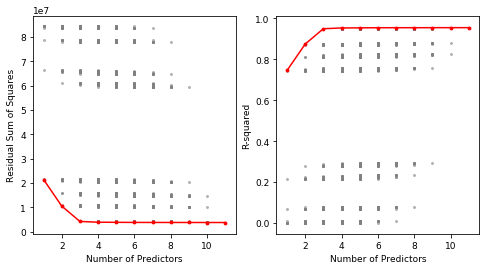

In [4]:
matplotlib.rcParams.update({'font.size': 9})
fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
#图像分为一行两列，当前位置1
ax1.scatter(Best_score.k, Best_score.RSS,color = 'grey',alpha = 0.5,s=4)
ax1.scatter(RSSmin.index, RSSmin,color = 'red',s=8)
ax1.plot(RSSmin.index, RSSmin,color = 'red')
ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('Residual Sum of Squares')
ax2.scatter(Best_score.k, Best_score.R2,color = 'grey',alpha = 0.5,s=4)
ax2.scatter(R2max.index, R2max,color = 'red',s=8)
ax2.plot(R2max.index, R2max,color = 'red')
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('R-squared')
plt.show()

现在为了选出一个最佳模型，我们必须从这些p+ 1中选择中挑选。这一任务必须谨慎执行，因为随着模型中包含的特征数量的增加，这些p + 1模型的RSS单调降低，$R^2$单调增加。问题是。低RSS或高$R^2$表明模型具有低训练误差，而我们希望选择具有低测试误差的模型因此请参见步骤3。我们使用交叉项的预测误差BIC， $C_p$，adiusted $R^2$，以从中MO,M1. ...Mp选择。这些方法将在第6.1.3节中讨论。

### 6.1.2 Stepwise Selection
由于计算的原因，subset selection 方法不能应用于很大的P值。并且一个过大的搜索范围会导致过度拟合。这是为什么stepwise方法具有很好的应用。
###### <font color="#0000dd">Algorithm 6.2 Forward Stepwise Selection</font>
正向的stepwise selection逐步选择从一个不包含解释变量的模型开始，然后一次一个地向模型中添加解释变量，直到所有的解释变量都在模型中。特别是，在每个步骤中，都会向模型中添加对拟合效果产生最大额外改善的变量。
1. 令 $M_0$ 代表 $null$ $model$, 不包含解释变量，该模型仅预测每次观测的样本平均值。
2. $k = 0,1,2,...p-1$:   
    (a) 对于所有 $p-k$ 个模型，每次扩大模型 $M_k$ 并向其中添加一个额外的变量。
    (b) 从这 $p-k$ 个模型中选择最合适的模型($M_{k+1}$). 最好的模型$Best$定义为拥有最小的 RSS 或者最大的 $R^2$。
3. 从 $M_0,...,M_p$中选择一个最好的模型，利用交互项的预测误差, $C_p$(AIC), BIC, 或者调整后的$R^2$     
即使在高维设置中也可以应用正向逐步选择当 n < p; 然而在这样的情况下, 只能构造 M0, . . . ,Mn−1 子模型.

In [1]:
#stepwise是一种线性回归的变量筛选方法：分为向前、向后，向前+向后3种。
def forsubset(y,X,krange=11):
    remain = list(X.columns)
    select = []
    score = pd.DataFrame()
    for k in range(1,krange+1):
        best = []
        for j in remain:
            model = sm.OLS(list(y),sm.add_constant(X[select+[j]]).astype(float)).fit()
            best.append([k,select+[j],model.ssr,model.rsquared])
        best = pd.DataFrame(best, columns =['k','var','RSS','R2'])
        best = best.sort_values('RSS').head(1)
        score = score.append(best)
        select.append(list(best['var'])[0][-1])
        remain.remove(list(best['var'])[0][-1])
    return score

In [6]:
forward = forsubset(y,X)
print(bestvar.sort_index(ascending = True).head(5))
print(forward[forward.k <= 5]['var'])
#print（bestvar.sort_index）

2                                        (Rating,)
12                                (Income, Rating)
79                   (Income, Rating, Student_Yes)
242            (Income, Limit, Cards, Student_Yes)
564    (Income, Limit, Rating, Cards, Student_Yes)
Name: var, dtype: object
2                                       [Rating]
0                               [Rating, Income]
5                  [Rating, Income, Student_Yes]
0           [Rating, Income, Student_Yes, Limit]
0    [Rating, Income, Student_Yes, Limit, Cards]
Name: var, dtype: object


###### <font color="#0000dd">Algorithm 6.3 Backward Stepwise Selection</font>
与正向的逐步选择一样，后向逐步选择提供了最佳子集选择的有效替代方案。然而，与正向逐步选择不同，它从包含所有p预测值的完全最小二乘模型开始，然后一次一个地迭代删除最不有用的预测值。
1. 令 $M_p$ 代表 $full$ $model$, 包括所有的解释变量. 
2. 对于 $k = p,p-1,...,1$:   
    (a) 对于 所有的$k$ 模型只不含所有解释变量中的一个，在模型 $M_k$中拥有 $k-1$ 个解释变量。  
    (b) 从 $k$个模型中选择最好的($M_{k-1}$). $最好的$ 定义为拥有最小的 RSS 或者最大的 $R^2$。
3. 从 $M_0,...,M_p$ 中选择一个最好的模型，利用交互项的预测误差, $C_p$(AIC), BIC, 或者调整后的 $R^2$

In [12]:
def backsubset(y,X,krange=11):
    remain = list(X.columns)
    score = pd.DataFrame()
    model = sm.OLS(list(y),sm.add_constant(X).astype(float)).fit()
    score = score.append(pd.DataFrame([11,list(X.columns),model.ssr,model.rsquared]).T)
    score.columns = ['k','var','RSS','R2']
    for k in range(krange-1,0,-1):
        best = []
        for j in remain:
            model = sm.OLS(list(y),sm.add_constant(X[remain].drop(j,axis=1)).astype(float)).fit()
            best.append([k,list(X[remain].drop(j,axis=1).columns),model.ssr,model.rsquared])
        best = pd.DataFrame(best, columns =['k','var','RSS','R2'])
        best = best.sort_values('RSS').head(1)
        score = score.append(best)
        remain = best.iloc[0,1]
    return score
#向前和向后选择的差别在于for循环不同

#### Hybrid Approaches
最佳子集、前向逐步和后向逐步选择方法通常给出相似但不完全相同的模型。作为另一种选择，可以使用正向和反向逐步选择的混合版本，其中变量按顺序添加到模型中，类似于正向选择。但是，在添加每个新变量后，该方法还可能删除不再提供模型拟合改进的任何变量。这种方法试图更优秀地模拟最佳子集选择，同时保留向前和向后逐步选择的计算优势。

### 6.1.3 选择最优模型

为了选择关于测试误差的最佳模型，我们需要估计该测试误差。有两种常见的方法：
1. 我们可以通过对训练误差进行**调整**来间接估计测试误差，以考虑过度拟合导致的偏差。
2. 我们可以**直接**使用验证集方法或交叉验证方法估算测试误差，如第5章所述。


#### $C_p$, AIC, BIC, and Adjusted $R^2$
特别是，当模型中包含更多变量时，训练误差将减小，但测试误差可能不会减小。因此，不能使用训练集RSS和训练集R2从一组具有不同数量变量的模型中进行选择。

但是，可以使用多种技术来调整模型的训练误差：
$$
C_p = \frac{1}{n}(RSS+2d\hat{\sigma}^2)
$$
其中$\hat{\sigma}^2$是与每个响应测量相关的误差$\epsilon$方差的估计值。虽然它超出了本书的范围，但可以证明如果$\hat{\sigma}^2$是$\sigma^2的无偏估计值$, 并且 $C_p$ 是一个 $MSE$ 的无偏估计。
$$
AIC = \frac{1}{n\hat{\sigma}^2}(RSS+2d\hat{\sigma}^2)
$$

$$
BIC = \frac{1}{n}(RSS+log(n)d\hat{\sigma}^2)
$$

$$
Adjusted R^2 = 1-\frac{RSS/(n-d-1)}{TSS/(n-1)}
$$
尽管它很受欢迎，而且非常直观，但调整后的$R^2$在统计理论上不如$AIC$、$BIC$和$C_p$具有直观的统计学和经济学上的意义。

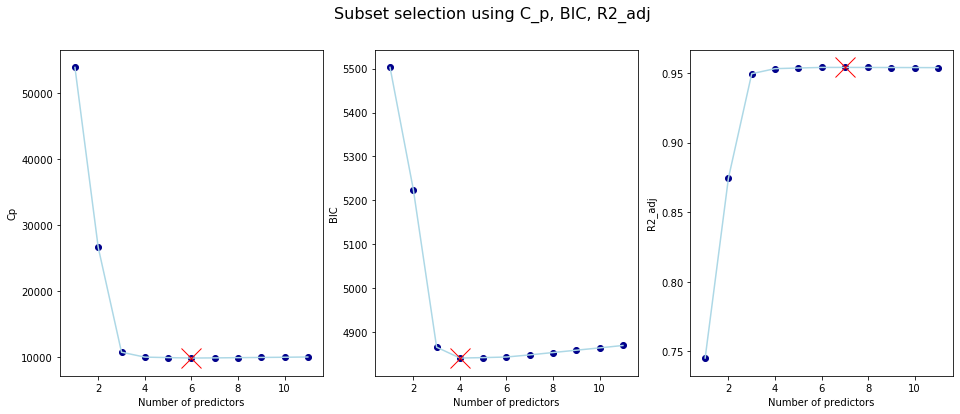

In [9]:
Best_score = Best_score.sort_values('RSS')
opt = Best_score.groupby('k').head(1)
opt = opt.set_index(['k'],drop = False)

variables = ['Cp','BIC','R2_adj']
matplotlib.rcParams.update({'font.size': 10})
fig = plt.figure(figsize = (16,6))
for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(opt['k'],opt[v], color = 'lightblue')
    ax.scatter(opt['k'],opt[v], color = 'darkblue')
    if v == 'R2_adj':
        ax.plot(opt[v].idxmax(),opt[v].max(), marker = 'x', markersize = 20,c='red')
    else:
        ax.plot(opt[v].idxmin(),opt[v].min(), marker = 'x', markersize = 20,c='red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)
#第一步先画出所有的点（蓝），第二步选出最合适的点（×）
#两两组合，R2_adj选最大，另两个选最小
fig.suptitle('Subset selection using C_p, BIC, R2_adj', fontsize = 16)
plt.show()

#### 验证和交叉验证
作为上述方法的替代方法，我们可以使用第5章中讨论的验证集和交叉验证方法直接估计测试误差。
优点是更直接、更灵活。
- 通过随机选择四分之三的观察数据作为训练集，其余数据作为验证集，计算验证误差。
- 交叉验证误差的计算采用k=10倍。

D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'k' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


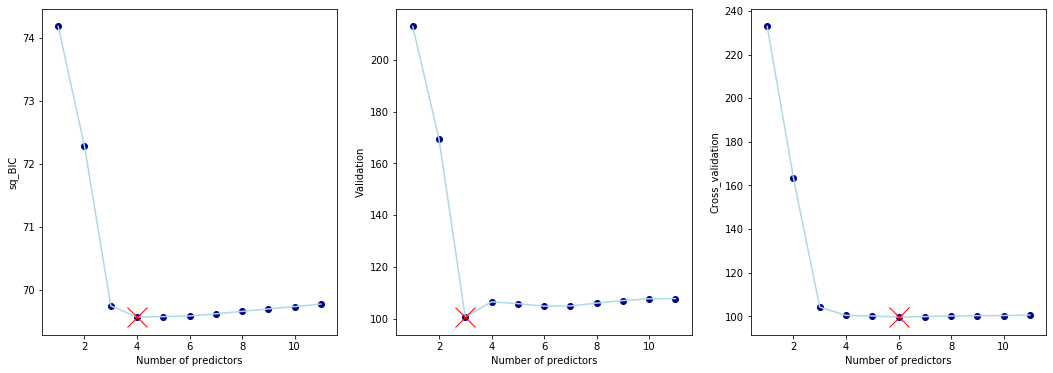

In [10]:
opt['sq_BIC'] = opt.BIC**0.5
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 123)
opt = opt.sort_values('k')
#将数据集拆分
vali = []
crvali = []
lr = LinearRegression()
for i in range(1,12):
    model = sm.OLS(y_train, sm.add_constant(X_train[list(opt['var'][i])])).fit()
    y_pred = model.predict(sm.add_constant(X_test[list(opt['var'][i])]))
    crerror = ((cross_val_score(lr,X[list(opt['var'][i])],y,cv = 10,scoring = 'neg_mean_squared_error').mean())*(-1))**0.5
    vali.append((((y_pred - y_test)**2).mean())**0.5)
#训练集与测试集间误差
    crvali.append(crerror)
opt['Validation'] = vali
opt['Cross_validation'] = crvali

variables = ['sq_BIC','Validation','Cross_validation']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(opt['k'],opt[v], color = 'lightblue')
    ax.scatter(opt['k'],opt[v], color = 'darkblue')
    ax.plot(opt[v].idxmin(),opt[v].min(), marker = 'x', markersize = 20,c='red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)
plt.show()

**一个标准误规则One-Standard-Error Rule**
如果我们重复验证集方法，使用不同的数据分割为训练集和验证集，或者如果我们重复交叉验证，使用不同的交叉验证折叠集，那么具有最低估计测试错误的精确模型肯定会改变。在此设置中，我们可以使用一个标准误规则选择模型。
我们首先计算每个模型尺寸的估计测试MSE的标准误差，然后选择估计测试误差在曲线最低点的一个标准误差范围内的最小模型。

#### Lab1: Subset Selection Methods

In [8]:
#如果我们重复验证集的方法使用不同的分割成训练集和验证集的数据，那么具有最低估计测试误差的精确模型肯定会改变。
#我们首先计算每个模型尺寸的估计检验MSE的标准误差，然后选择估计检验误差在曲线最低点一个标准误差以内的最小模型
Hitters = pd.read_csv('Hitters.csv')
Hitters = pd.get_dummies(Hitters, columns = ['League','Division','NewLeague'],drop_first = True)
Hitters = Hitters.dropna(axis = 0)
Hitters = Hitters.iloc[:,1:] # 去掉name
print(Hitters)
print(Hitters.columns)
np.shape(Hitters)

     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
1      315    81      7    24   38     39     14    3449    835      69   
2      479   130     18    66   72     76      3    1624    457      63   
3      496   141     20    65   78     37     11    5628   1575     225   
4      321    87     10    39   42     30      2     396    101      12   
5      594   169      4    74   51     35     11    4408   1133      19   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...   
317    497   127      7    65   48     37      5    2703    806      32   
318    492   136      5    76   50     94     12    5511   1511      39   
319    475   126      3    61   43     52      6    1700    433       7   
320    573   144      9    85   60     78      8    3198    857      97   
321    631   170      9    77   44     31     11    4908   1457      30   

     CRuns  CRBI  CWalks  PutOuts  Assists  Errors  Salary  League_N  \
1      321   414     375   

(263, 20)

In [ ]:
Best_score2 = BestSubset(Hitters.Salary,Hitters.drop('Salary',axis=1),krange=19)
# 非常耗时
Best_score2 = pd.DataFrame(Best_score2, columns= ['k','var','RSS','R2','R2_adj','AIC','BIC'])
Best_score2['Cp'] = (Best_score2.RSS + 2*Best_score2.k*(Best_score2.RSS/(n-1-Best_score2.k)))/n
#Best_score2 = Best_score2.sort_values('RSS')
bestMk = Best_score2.groupby('k').head(1)
bestMk = bestMk.set_index(['k'],drop = False)

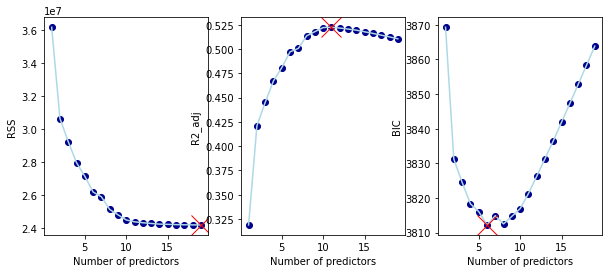

In [7]:
#bestMk = pd.read_csv('bestMk.csv',index_col=0)
bestMk.columns = ['k','var','RSS','R2','R2_adj','AIC','BIC','Cp']

#RSSmin2 = Best_score2.groupby('k').RSS.min()
#R2max2 = Best_score2.groupby('k').R2.max()
#bestvar2 = Best_score2.groupby('k').head(1)['var']
variables = ['RSS','R2_adj','BIC']
matplotlib.rcParams.update({'font.size': 10})

fig = plt.figure(figsize = (10,4))
for i,v in enumerate(variables):
    ax = fig.add_subplot(1,3, i+1)
    ax.plot(bestMk['k'],bestMk[v], color = 'lightblue')
    ax.scatter(bestMk['k'],bestMk[v], color = 'darkblue')
    if v == 'R2_adj':
        ax.plot(bestMk[v].idxmax(),bestMk[v].max(), marker = 'x', markersize = 20,c='red')
    else:
        ax.plot(bestMk[v].idxmin(),bestMk[v].min(), marker = 'x', markersize = 20,c='red')
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)
plt.show()

In [15]:
forward2 = forsubset(Hitters.Salary,Hitters.drop('Salary',axis=1),krange=19)
backward2 = backsubset(Hitters.Salary,Hitters.drop('Salary',axis=1),krange=19)
##分别从三种模型选择方法之中选择最优模型
print(list(bestMk[bestMk.k == 7]['var']))
print(list(forward2[forward2.k == 7]['var']))
print(list(backward2[backward2.k == 7]['var']))
#最终选出最优模型为k等于7时

["('Hits', 'Walks', 'CAtBat', 'CHits', 'CHmRun', 'PutOuts', 'Division_W')"]
[['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks']]
[['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts', 'Division_W']]


## 6.2 Shrinkage Methods
As an alternative, we can fit a model containing all p predictors using a technique that constrains or regularizes the coefficient estimates, or equivalently, that shrinks the coefficient estimates towards zero.The two best-known techniques for shrinking the regression coefficients towards zero are $ridge$ $regression$ and the $lasso$.

### 6.2.1 Ridge Regression
$$
RSS = \sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx^{ij})^2
$$
Ridge regression is very similar to least squares, except that the coefficients ridge regression are estimated by minimizing a slightly different quantity.In particular, the ridge regression coefficient estimates $\hat{\beta}^R$ are the values that minimize
$$
\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda\sum_{j=1}^{p}\beta_j^2 = RSS + \lambda\sum_{j=1}^{p}\beta_j^2
$$
where $\lambda ≥ 0$ is a tuning parameter, to be determined separately.$\lambda\sum_{j=1}^{p}\beta_j^2$ is called $shrinkage$ $penalty$. 
When $\lambda = 0$, the penalty term has no effect, and ridge regression will produce the least squares estimates. However, as $\lambda \rightarrow ∞$, the impact of the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero.Selecting a good value for $\lambda$ is critical; we defer this discussion to Section 6.2.3, where we use cross-validation.   
Note that the shrinkage penalty is applied to $\beta_1, . . . , \beta_p$, but not to the intercept $\beta_0$.

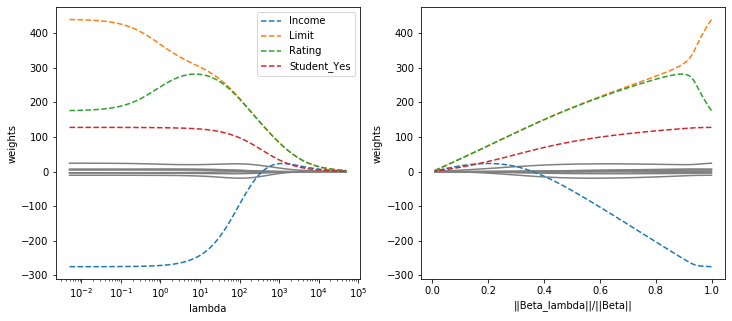

In [19]:
alphas = 10**np.linspace(-2,5,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = pd.DataFrame(coefs, columns = X.columns)

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
the4var = ['Income','Limit','Rating','Student_Yes']
ax1.plot(alphas, coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax1.plot(alphas, coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('weights')
ax1.legend()

a = 0
ridge.set_params(alpha=a)
ridge.fit(scale(X), y)
B2 = (ridge.coef_**2).sum()
coefs['BR2'] = np.sqrt(((coefs**2).T).sum()/B2)

ax2.plot(coefs['BR2'], coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax2.plot(coefs['BR2'], coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax2.set_xlabel('||Beta_lambda||/||Beta||')
ax2.set_ylabel('weights')
plt.show()

##### Why Does Ridge Regression Improve Over Least Squares?
Ridge regression’s advantage over least squares is rooted in the bias-variance trade-off. As $\lambda$ increases, the shrinkage of the ridge coefficient estimates leads to a substantial reduction in the variance of the predictions, at the expense of a slight increase in bias.
**This trade off relation was displayed in Chapter 5.**

### 6.2.2 The Lasso
Unlike best subset, forward stepwise, and backward stepwise selection, which will generally select models that involve just a subset of the variables, ridge regression will include all $p$ predictors in the final model.This may not be a problem for prediction accuracy, but it can create a challenge in model interpretation in settings in which the number of variables $p$ is quite large.The lasso is a relatively recent alternative to ridge regression that overcomes this disadvantage.The lasso coefficients minimize the quantity:
$$
\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2 + \lambda\sum_{j=1}^{p}|\beta_j| = RSS + \lambda\sum_{j=1}^{p}|\beta_j|
$$
In statistical parlance, the lasso uses an $l1$ penalty instead of an $l2$ penalty.In the case of the lasso, the $l1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large.

D:\Users\longzhen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
D:\Users\longzhen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
D:\Users\longzhen\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0, 0.5, 'weights')

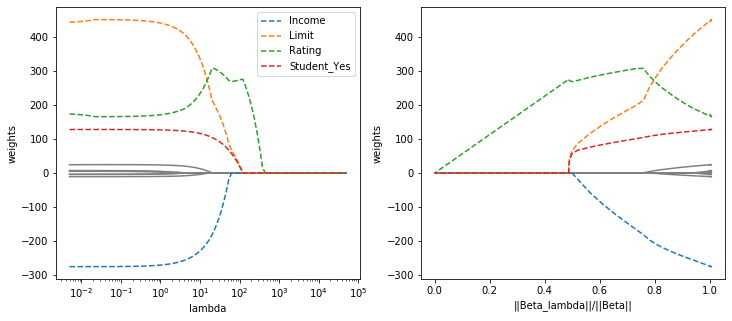

In [20]:
# Lasso
ridge = Lasso()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
coefs = pd.DataFrame(coefs, columns = X.columns)

fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
the4var = ['Income','Limit','Rating','Student_Yes']
ax1.plot(alphas, coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax1.plot(alphas, coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('weights')
ax1.legend()

a = 0
ridge.set_params(alpha=a)
ridge.fit(scale(X), y)
B2 = (ridge.coef_**2).sum()
coefs['BR2'] = np.sqrt(((coefs**2).T).sum()/B2)

ax2.plot(coefs['BR2'], coefs.drop(the4var,axis=1),color = 'grey')
for i in range(4):
    ax2.plot(coefs['BR2'], coefs[the4var[i]],label = the4var[i],linestyle = '--')
ax2.set_xlabel('||Beta_lambda||/||Beta||')
ax2.set_ylabel('weights')

##### Another formula for Ridge Regression and Lasso
$$
minimize\left\{\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2\right\} s.t. \sum_{j=1}^{p}|\beta_j|\leqslant s
$$


$$
minimize\left\{\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2\right\} s.t. \sum_{j=1}^{p}\beta_j^2\leqslant s
$$

In other words, for every value of $λ$, there is some $s$ that will give the same lasso coefficient estimates.Similarly, for every value of $λ$ there is a corresponding $s$ such that will give the same ridge regression coefficient estimates. When $p = 2$, then it indicates that the lasso coefficient estimates have the smallest RSS out of all points that lie within the diamond defined by $|β_1| + |β_2| ≤ s$. Similarly, the ridge regression estimates have the smallestRSS out of all points that lie within the circle defined by $β_1^2 + β_2^2 ≤ s$.   
Consider 
$$
minimize\left\{\sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}\beta_jx_{ij})^2\right\} s.t. \sum_{j=1}^{p}I(\beta_j≠0)\leqslant s
$$
The problem amounts to finding a set of coefficient estimates such that RSS is as small as possible, subject to the constraint that no more than s coefficients can be nonzero. The problem is equivalent to best subset selection.Unfortunately, this is computationally infeasible when p is large, since it requires considering
all $C_p^k$ models containing s predictors. Therefore, we can interpret ridge regression and the lasso as computationally feasible alternatives to best subset selection that replace the intractable form of the budget with forms that are much easier to solve. Of course, the lasso is much more closely related to best subset selection, since only the lasso performs feature selection for s sufficiently small.

###### Comparing the Lasso and Ridge Regression
Lasso selects variables while Ridge Regressions only shrink the parameters. It is clear that the lasso has a major advantage over ridge regression, in that it produces simpler and more interpretable models that involve only a subset of the predictors.

###### A Simple Special Case for Ridge Regression and the Lasso
In order to obtain a better intuition about the behavior of ridge regression and the lasso, consider a simple special case with n = p, and X a diagonal matrix with 1’s on the diagonal and 0’s in all off-diagonal elements. To simplify the problem further, assume also that we are performing regression without an intercept.
We can calculate the results that the Ridge Regression estimates take the form:
$$
\hat{\beta}_j^R = y_j/(1+\lambda)
$$
And the Lasso estimates take the form:
$$
\hat{\beta}_j^L=\left\{
\begin{array}{rcl}
y_j-\lambda/2       &      & {y_j      >      \lambda/2}\\
y_j+\lambda/2     &      & {y_j      <      -\lambda/2}\\
0   &      & {otherwise}
\end{array} \right.
$$
We can see that ridge regression and the lasso perform two very different types of shrinkage. In ridge regression, each least squares coefficient estimate is shrunken by the same proportion.In contrast, the lasso shrinks each least squares coefficient towards zero by a constant amount, λ/2; the least squares coefficients that are less than λ/2 in absolute value are shrunken entirely to zero.The type of shrinkage performed by the lasso in this simple setting is known as $soft-thresholding$. The fact that some lasso coefficients are shrunken entirely to soft-thresholding zero explains why the lasso performs feature selection.

### 6.2.3 Selecting the Tuning Parameter

Cross-validation provides a simple way to tackle this problem. We choose a grid of λ values, and compute
the cross-validation error for each value of λ, as described in Chapter 5. We then select the tuning parameter value for which the cross-validation error is smallest. Finally, the model is re-fit using all of the available observations and the selected value of the tuning parameter.

### Lab 2: Ridge Regression and the Lasso

In [3]:
Hitters = pd.read_csv('Hitters.csv')
Hitters = pd.get_dummies(Hitters, columns = ['League','Division','NewLeague'],drop_first = True)
Hitters = Hitters.dropna(axis = 0)
Hitters = Hitters.iloc[:,1:] # 去掉name
y = Hitters.Salary
X = Hitters.drop('Salary',axis=1)

X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

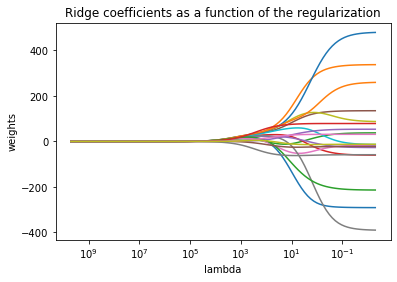

In [4]:
alphas = 10**np.linspace(10,-2,100)*0.5
ridge = Ridge()
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
ridge2 = Ridge(alpha=705)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
print(mean_squared_error(y_test, pred))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

118482.9670665639


AtBat          12.870669
Hits           15.188099
HmRun          12.411658
Runs           14.878940
RBI            15.346209
Walks          22.975651
Years           6.130568
CAtBat         14.090004
CHits          15.932278
CHmRun         12.315527
CRuns          17.630390
CRBI           14.205774
CWalks         15.290584
PutOuts         5.870662
Assists       -13.413488
Errors         19.460360
League_N        3.187834
Division_W      2.501010
NewLeague_N     5.305309
dtype: float64

In [7]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
print(mean_squared_error(y_test, pred))

193253.09741651407


In [8]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)
ridgecv.alpha_

115.50648500415791

In [9]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

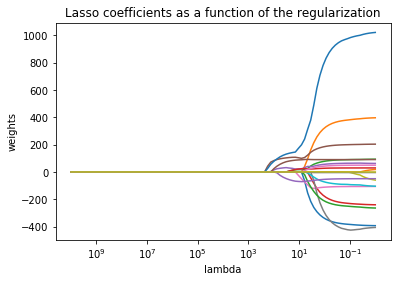

In [10]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');
plt.show()

In [11]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())
lassocv.alpha_

30.01382256446427

In [12]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64